<a href="https://colab.research.google.com/github/baigouy/notebooks/blob/master/EPySeg_segment_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Before you start

__Note: You are using this at your own risk__, the author cannot be help responsible for damage to Google drive or misfunction of the e-mail account (due to drive overfilling). To avoid issues please use a second account dedicated to deep learning. __If you disagree, please quit this page__.

[General colab notebook tips](https://github.com/baigouy/notebooks#getting-started)

Please report bugs to baigouy@gmail.com

# Step 1:
- Mount Google drive ([How to](https://github.com/baigouy/notebooks#how-to-mount-google-drive-in-colab)).
- Select a GPU runtime ([How to](https://github.com/baigouy/notebooks#select-a-gpu-runtime)).
- Then run the code cell below ([How to](https://github.com/baigouy/notebooks#how-to-run-a-code-cell)).

In [2]:
#@title <-- Press Run

%tensorflow_version 2.x
import tensorflow as tf
import sys
from __future__ import print_function
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import Markdown, display
import os

# defining an html/md formatting print function
def printmd(string):
    display(Markdown(string))

# defining a filebrowser that can be used later on
# FileBrowser modified from DrDub https://gist.github.com/DrDub/6efba6e522302e43d055 PD licence
# new beahviour: single click selects a file or a folder, double click browses folders. Blocked browsing of files as if they were folders. Has an option to show files or not (files are shown by default).
# Note that I have made a very quick n dirty hack of the initial nice code so that it handles double click, my changes would need some love but it seems functional, please report bugs to BA otherwise
# TODO also maybe hack it to select files only or folders or maybe ignore and do the check later and put a warning accordingly (maybe simpler for now)


import os
import ipywidgets as widgets
from ipywidgets import Layout, Button, VBox, Label,Box, HBox, ButtonStyle
from timeit import default_timer as timer

class FileBrowser(object):
    def __init__(self, width='auto', height="200px", item_width="auto", item_height="auto", folders_only=False):
        
        self.folders_only = folders_only
        self.path = os.getcwd()
        self._update_files()
        
        self.layout = Layout(overflow='scroll',
                             border ='1px solid black',
                             width  ='{}'.format(width),
                             height ='{}'.format(height),
                             flex_flow = "column wrap",
                             align_items = "flex-start",
                             display='flex')
        
        self.button_dir_syle  = ButtonStyle(button_color='lightgray')
        self.button_file_syle = ButtonStyle(button_color='#Fafaff')
        
        self.button_layout    = Layout(left="0px", width="{}".format(item_width), height="{}".format(item_height))
        self.last_click = None
        self.root_folder = None
        
        
    def _update_files(self):
        self.files = list()
        self.dirs  = list()
        # print('is dir', self.path, os.path.isdir(self.path))
        if(os.path.isdir(self.path)):
            for f in os.listdir(self.path):
                ff = os.path.join(self.path,f)
                if os.path.isdir(ff):
                    self.dirs.append(f)
                else:
                    self.files.append(f)
        
    def widget(self):
        list_box = widgets.Box(layout=self.layout)
        box = VBox([list_box, Label(self.path)])
        self._update_box(box)
        
        return box
    
    
    def _update_box(self, main_box, double_click=True):
        # print('double click in there', double_click)
        path_label = main_box.children[1]
        file_or_path = "Selected file: {}"
        if os.path.isdir(self.path):
          file_or_path = "Selected path: {}"
        path_label.value = file_or_path.format(self.path)
        
        if self.root_folder is None:
          self.root_folder = self.path

        box        = main_box.children[0]
        if not double_click:
          # print('skipping')
          return box
        else:
          if (os.path.isfile(self.path)):
            # prevent 'browsing' files
            return box
          # print('starting path', self.path)
          self.root_folder = self.path
        
        def on_click(b):
            double_click = False

            # detect single or double click and act accordingly (dirty hack by BA)
            if self.last_click is not None:
              # print('delay',timer()-self.last_click)
              if timer()-self.last_click<=0.600:
                # print('double click')
                double_click = True
              else:
                # print('single click')
                self.last_click = timer()
            else:
              self.last_click = timer()  
              # print('single click')          

            if b.description == '..':
                if not double_click: #skip double click for previous folder
                  self.path = os.path.split(self.root_folder)[0]

                double_click=True
                # print('path parent',self.path)
            else:
                if not double_click:
                  self.path = os.path.join(self.root_folder, b.description)
                else:
                  self.path = os.path.join(self.root_folder, b.description)
                  # keep path in fact
                  # print('double click path', self.path)
            
            # print('cur', self.path)
            # if double_click:
            self._update_files()
            self._update_box(main_box, double_click)
            # self.last_click = None

        buttons = []
        if os.path.dirname(self.path) != self.path:
            button = widgets.Button(description='..', style=ButtonStyle(button_color='lightblue'), layout=self.button_layout)
            button.on_click(on_click)
            buttons.append(button)
        
        for f in self.dirs:
            button = widgets.Button(description=f, style=self.button_dir_syle, icon='fa-folder', tooltip=f, layout=self.button_layout)
            button.on_click(on_click)
            buttons.append(button)
        
        if not self.folders_only:
          for f in self.files:
              button = widgets.Button(description=f, style=self.button_file_syle, tooltip=f, layout=self.button_layout)
              button.on_click(on_click)
              buttons.append(button)
            
        box.children = buttons


try:
  # check that google drive is successfully mounted
  
  if os.path.exists('/content/drive/My Drive'):#/content/dri #create an error # /content/drive/My Drive # full path
    printmd('<font color="green">Google drive successfully mounted!</font>')
    # move to the drive folder
    %cd /content/drive/My Drive
  else:
    from google.colab import drive
    printmd('<font color="green"><b>Open the external link and follow the instructions until you get the authorization code. Copy this code, paste it below then press "Enter"</b></font>')
    drive.mount('/content/drive')

    if not os.path.exists('/content/drive/My Drive'):
      printmd('<font color="red">Please connect to Google drive and repeat this step:</font>')
      print('How to: https://github.com/baigouy/notebooks#how-to-mount-google-drive-in-colab') # could be useful indeed
      #assert False
      raise Exception('error!')
    else:
      # move to the drive folder
      %cd /content/drive/My Drive
      printmd('<font color="green">Google drive successfully mounted!</font>')
    # sys.exit()
    #quit(keep_kernel=False)

  # check we are using GPU
  device_name = tf.test.gpu_device_name()
  if device_name != '/device:GPU:0':
    printmd('<font color="red">GPU not found, please repeat this step.</font>')
    print('How to: https://github.com/baigouy/notebooks#select-a-gpu-runtime') # could be useful indeed
    # should also do that first and print the link to help people use this stuff!!!
    # quit
    raise Exception('error!')
  else:
    printmd('<font color="green">GPU found!</font>')
    # should I merge all in one single step because if anyway anything fails it is not gonna work...
    # maybe it's an idea

  printmd('<br><font color="green">Everything went fine, please move on to next step!</font>')
except:
  pass


# printmd('this is a test')

<font color="green"><b>Open the external link and follow the instructions until you get the authorization code. Copy this code, paste it below then press "Enter"</b></font>

Mounted at /content/drive
/content/drive/My Drive


<font color="green">Google drive successfully mounted!</font>

<font color="green">GPU found!</font>

<br><font color="green">Everything went fine, please move on to next step!</font>

# Step 2:
- Install the required python libraries by running the code cell below (please be patient, this may take time...)

In [3]:
#@title <-- Press Run

# slow --> keep it as a separate step
# install python libraries necessary to run epyseg
# TODO check that all those libs are reallyu required but ok for now
!pip install czifile
!pip install h5py
!pip install Markdown
!pip install matplotlib
!pip install numpy
!pip install numpydoc
!pip install Pillow
!pip install PyQt5
!pip install PyQtWebEngine
!pip install read-lif
!pip install scikit-image
!pip install scipy
!pip install segmentation-models==1.0.1
!pip install tifffile
!pip install natsort
!pip install numexpr
!pip install --no-deps epyseg # prevent reinstalling tf 2.x and rather use the google optimized tf
# !pip install --no-deps --user https://test.pypi.org/project/epyseg/0.1.14/
# !pip install --no-deps --index-url https://test.pypi.org/simple/ epyseg




# libraries loaded checking epyseg to see if everything is functional
try:
  from epyseg.img import Img
  # just try import any class from Epyseg --> will raise an error if loading fails if loads most likely everything should work
  from epyseg.deeplearning.deepl import EZDeepLearning
  from epyseg.deeplearning.augmentation.meta import MetaAugmenter
  from epyseg.deeplearning.augmentation.generators.data import DataGenerator
  deepTA = EZDeepLearning()
  printmd('<br><font color="green">EPySeg succesfully loaded, please move on to next step!</font>') 
except:
  printmd('<br><font color="red">EPySeg failed to load. Please repeat this step</font>.')

Using tensorflow version 2.3.0
Using segmentation models version 1.0.1


<br><font color="green">EPySeg succesfully loaded, please move on to next step!</font>

# Step 3
- Run the cell below and choose between loading or building a model, then move to next cell.

In [3]:
#@title <-- Press Run

label = widgets.Label('Please make a choice:')
# cannot be horizontal https://github.com/jupyter-widgets/ipywidgets/issues/1247
options = [['Load a model (pretrained to segment epithelia)',1], ['Load a custom model',2] ] #,['Use a pre-trained model',3]
model = widgets.RadioButtons(options=options)

ui = widgets.VBox([label, model])
display(ui) 

# Step 4
- Please run the cell below and follow output instructions

In [4]:
#@title <-- Press Run

if model.value == 1:
  # # load a pre trained model
  # available_pretrained_models_label = Label('Please select the pretrained model (then move on to next step):')
  # # get all available model architectures
  available_pretrained_models = deepTA.get_available_pretrained_models()
  # # print(available_pretrained_models)
  # available_pretrained_models_drop = widgets.Dropdown(
  #     # value='Linknet',
  #     placeholder='Choose a model',
  #     options=available_pretrained_models,
  #     description='Pretrained models',
  #     ensure_option=True,
  #     disabled=False,
  #     layout={'width': 'max-content'},
  #     style={'description_width': 'initial'}
  # )
  # ui = widgets.VBox([available_pretrained_models_label, available_pretrained_models_drop])
  # display(ui) 
  printmd('<br><font color="green">Please move on to next step!</font>')
elif model.value == 2:
  # browse for input model
  load_model_label = Label('Please select a model file and move on to next step:')
  model_path = FileBrowser(folders_only=False) #item_width="140px"
  ui = widgets.VBox([load_model_label, model_path.widget()])
  display(ui)


<br><font color="green">Please move on to next step!</font>

# Step 5
- Please run the cell below to load the model

In [5]:
#@title <-- Press Run

deepTA.model = None # does it really reset model or not
try:
  # First we try to build or load the model and if something goes wrong ask to repeat step 4
  if model.value == 1:
    # Load a pre-trained model
    pretrained_model_parameters = deepTA.pretrained_models_2D_epithelia['Linknet-vgg16-sigmoid']
    # print(pretrained_model_parameters)
    deepTA.load_or_build(model=pretrained_model_parameters['model'], model_weights=pretrained_model_parameters['model_weights'], architecture=pretrained_model_parameters['architecture'], backbone=pretrained_model_parameters['backbone'], activation=pretrained_model_parameters['activation'], classes=pretrained_model_parameters['classes'], input_width=pretrained_model_parameters['input_width'], input_height=pretrained_model_parameters['input_height'], input_channels=pretrained_model_parameters['input_channels'],pretraining='Linknet-vgg16-sigmoid')

  elif model.value == 2:
    # try to load an existing model and report error if model could not be loaded
    # check wether model can be loaded 

    path = model_path.path
    if not os.path.exists(path):
      printmd('<font color="red">Please provide a valid model path. </font>')
      raise Exception('error!')
    else:
      # try load the model and return error upon failure
      # printmd('<font color="red">test!</font>')
      deepTA.load_or_build(model=path)

      
  if deepTA.model is None:
    printmd('<font color="red">Empty model!</font>')
    raise Exception('error!')
  else:
    deepTA.summary()
    printmd('<font color="green">Model succesfully loaded, please move on to next step!</font>')

except:

  printmd('<font color="red">Something went wrong, please repeat steps 4 and 5</font>')
  pass

Model file is not up to date
0.0 %
1.0 %
2.0 %
3.0 %
4.0 %
5.0 %
6.0 %
7.0 %
8.0 %
9.0 %
10.1 %
11.1 %
12.1 %
13.1 %
14.1 %
15.1 %
16.1 %
17.1 %
18.1 %
19.1 %
20.1 %
21.1 %
22.1 %
23.1 %
24.1 %
25.1 %
26.1 %
27.1 %
28.2 %
29.2 %
30.2 %
31.2 %
32.2 %
33.2 %
34.2 %
35.2 %
36.2 %
37.2 %
38.2 %
39.2 %
40.2 %
41.2 %
42.2 %
43.2 %
44.2 %
45.2 %
46.2 %
47.3 %
48.3 %
49.3 %
50.3 %
51.3 %
52.3 %
53.3 %
54.3 %
55.3 %
56.3 %
57.3 %
58.3 %
59.3 %
60.3 %
61.3 %
62.3 %
63.3 %
64.3 %
65.3 %
66.4 %
67.4 %
68.4 %
69.4 %
70.4 %
71.4 %
72.4 %
73.4 %
74.4 %
75.4 %
76.4 %
77.4 %
78.4 %
79.4 %
80.4 %
81.4 %
82.4 %
83.4 %
84.5 %
85.5 %
86.5 %
87.5 %
88.5 %
89.5 %
90.5 %
91.5 %
92.5 %
93.5 %
94.5 %
95.5 %
96.5 %
97.5 %
98.5 %
99.5 %
File saved as /root/.keras/epyseg/Linknet-vgg16-sigmoid.h5


INFO - 2020-10-21 07:17:35,767 - deepl.py - load_weights - line 656 - Loading weights ' /root/.keras/epyseg/Linknet-vgg16-sigmoid.h5'

INFO - 2020-10-21 07:17:35,985 - deepl.py - summary - line 677 - None



Model: "Linknet-vgg16-sigmoid-pretrained"
______________________________________________________________________________________________________________________________________________________
Layer (type)                                     Output Shape                     Param #           Connected to                                      
input_1 (InputLayer)                             [(None, None, None, 1)]          0                                                                   
______________________________________________________________________________________________________________________________________________________
block1_conv1 (Conv2D)                            (None, None, None, 64)           640               input_1[0][0]                                     
______________________________________________________________________________________________________________________________________________________
block1_conv2 (Conv2D)                            (No

<font color="green">Model succesfully loaded, please move on to next step!</font>

# Step 6
- Run the cell below and follow the instructions

In [9]:
#@title <-- Press Run

if model.value == 1:
  printmd('<font color="green">Please move on to next step.</font>')
elif model.value == 2:
  #@title <-- Press Run

  f = FileBrowser(folders_only=False) #item_width="140px"
  options2 = [['No',2],['Yes',1] ] #,['Use a pre-trained model',3]    
  drop_load_weights = widgets.Dropdown(options=options2, description='Load model weights:', layout={'width': 'max-content'}, style={'description_width': 'initial'})

  def browse_for_weights(x):
      if x == 1:
        weight_label = Label('Please select a weight file in your drive, then move on to next step:')
        ui = widgets.VBox([weight_label, f.widget()])
        display(ui)
      else:
        weight_label = Label('No weights to load, then please move on to next step')
        display(weight_label)


  interact(browse_for_weights, x=drop_load_weights);



<font color="green">Please move on to next step.</font>

# Step 7
- Run the cell below and follow the instructions

In [10]:
#@title <-- Press Run

if model.value == 1:
  printmd('<font color="green">Please move on to next step.</font>')
elif model.value == 2:
  if drop_load_weights.value == 1:
    try:
      deepTA.load_weights(f.path)
      printmd('<font color="green">Weights succesfully loaded. Please move on to next step!</font>')
    except:
      printmd('<font color="red">Something went wrong (file corrupt/wrong file), please repeat step 6.</font>')
  else:
    printmd('<font color="green">Please move on to next step!</font>')

<font color="green">Please move on to next step.</font>

# Step 8
- Please choose a folder containing images to segment

In [11]:
#@title <-- Press Run

folder_train_originals = FileBrowser(folders_only=True)
folder_train_originals_label = Label('Please select the folder in your drive that contains the original images to use for training (then move on to next step):')
ui = widgets.VBox([folder_train_originals_label, folder_train_originals.widget()])
display(ui)

# Step 9
-Run the cell below to check the input folder

originals n= 12
first original image


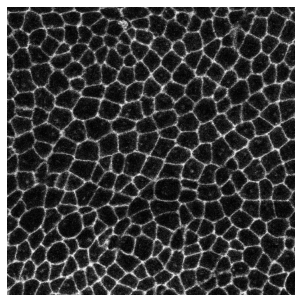

<Figure size 432x288 with 0 Axes>

(512, 512, 3)


<font color="green">Everything seems fine, please move on to next step.</font>

In [12]:
#@title <-- Press Run

# print(folder_train_originals.path)

originals_list = DataGenerator.get_list_of_images(folder_train_originals.path)
# print(originals_list)
print('originals n=',len(originals_list))

first_orig = None

if len(originals_list) > 0:
  try:
    print('first original image')
    first_orig = Img(originals_list[0])
    first_orig.pop()
    print(first_orig.shape)
    printmd('<font color="green">Everything seems fine, please move on to next step.</font>')
  except:
    printmd('<font color="red">Problems detected. The first image could not be loaded. Please check your files and repeat step 8.</font>')    
else:
    printmd('<font color="red">Problems detected. The folder seems empty. Please repeat step 8.</font>')


# Step 10
- Please run the cell below to define normalization and clip model input images (original images)

In [13]:
#@title <-- Press Run

# Normalization for orig data

info_label_orig=widgets.Label('If you don\'t know what to do, just leave pamaters unchanged and move on to next step.')

# if image has no or 1 channel then ignore COI
channels_orig = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
if first_orig is not None:
  if first_orig.has_c():
    channels_orig = []
    for c in range(first_orig.get_dimension('c')):
      channels_orig.append(c)
  else:
    channels_orig = [0]

channel_COI_orig = widgets.Dropdown(
    placeholder='Choose a channel of interest',
    options=channels_orig,
    description='Channel of interest (COI)',
    ensure_option=True,
    disabled=False,
    layout={'width': 'max-content'},
    style={'description_width': 'initial'}
)

rule_reduc_orig = widgets.Dropdown(
    placeholder='Rule to reduce nb of channels (if needed)',
    options=['copy the COI to all available channels','force copy the COI to all available channels even if nb of channels is ok','remove extra channels'],
    description='Rule to reduce nb of channels (if needed)',
    ensure_option=True,
    disabled=False,
    layout={'width': 'max-content'},
    style={'description_width': 'initial'}
)

rule_aug_orig = widgets.Dropdown(
    placeholder='Rule to increase nb of channels (if needed)',
    options=['copy the COI to all channels', 'force copy the COI to all available channels even if nb of channels is ok', 'copy the COI to missing channels only', 'add empty channels (0 filled)'],
    description='Rule to increase nb of channels (if needed)',
    ensure_option=True,
    disabled=False,
    layout={'width': 'max-content'},
    style={'description_width': 'initial'}
)


# TODO REMOVE LINE BELOW AND UPDATE LIBRARY!!!!
# ̣̣̣!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Img.clipping_methods = ['ignore outliers', '+', '+/-', '-']

# list of available normalization methods
# print(Img.normalization_methods)
# Img.normalization_ranges =[[0, 1], [-1, 1]]
# print('a',Img.normalization_ranges)
ranges = Img.normalization_ranges.copy()
# print(ranges)

for n,r in enumerate(ranges):
  # print(r,n, str(r))
  ranges[n]=str(r)

# print(ranges)

normalization_methods_orig = widgets.Dropdown(
    # value='Rescaling (min-max normalization)',
    placeholder='Normalization',
    options=Img.normalization_methods,
    description='Normalization method',
    ensure_option=True,
    disabled=False,
    layout={'width': 'max-content'},
    style={'description_width': 'initial'}
)
normalization_range_orig = widgets.Dropdown(
    # value='[0, 1]',
    placeholder='Range',
    options=ranges,
    description='Normalization range',
    ensure_option=True,
    disabled=False,
    # layout={'width': 'max-content'},
    style={'description_width': 'initial'}
)
clipping_methods_orig = widgets.Dropdown(
    placeholder='Clipping outliers',
    options=Img.clipping_methods,
    description='clip intensity',
    ensure_option=True,
    disabled=False,
    layout={'width': 'max-content'},
    style={'description_width': 'initial'}
)

per_channel_orig = widgets.Checkbox(True,
                       description='Per channel normalization',
                       style={'description_width': 'initial'}
)

cliprange_orig = widgets.FloatSlider(description='range (clipping)', value=0.05, min=0, max=0.25, step=0.01,style={'description_width': 'initial'})

# display(per_channel)
# def changed(b):
#     print(b)

# per_channel.observe(changed)

# wdgts = []
# ui = widgets.VBox(wdgts)
# display(ui)

invert_orig = widgets.Checkbox(False,
                       description='Negative/invert intensity',
                       style={'description_width': 'initial'}
)


# print(range_value)
# print(per_channel.value) #recover checkbox value

ui = widgets.VBox([info_label_orig, channel_COI_orig, rule_reduc_orig, rule_aug_orig, normalization_methods_orig, normalization_range_orig, per_channel_orig, clipping_methods_orig,  cliprange_orig, invert_orig])
display(ui)



# Step 11
- Please run the cell to set the tiling parameters (to reduce memory usage)

In [14]:
#@title <-- Press Run

test_boolean = True # True # I can have a conditional GUI in fact
wdgts = []

input_shape = deepTA.get_inputs_shape()
output_shape = deepTA.get_outputs_shape()

# so far assume model has one entry and one output maybe allow several inputs and outputs later
# print('model input shape', input_shape[0])
# print('model output shape', output_shape[0])

input_val_width = 128
input_val_height = 128
if input_shape[0][-2] is not None:
  # print(input_shape[0][-2]) # default tile width
  input_val_width=input_shape[0][-2]
  test_boolean = False
if input_shape[0][-3] is not None:
  # print(input_shape[0][-3]) # default tile height
  input_val_height=input_shape[0][-3]
  test_boolean = False

tile_width_slider = widgets.IntSlider(description='tile width', value=input_val_width, min=16, max=1024, step=2,style={'description_width': 'initial'})
wdgts.append(tile_width_slider)
tile_height_slider = widgets.IntSlider(description='tile height', value=input_val_height, min=16, max=1024, step=2,style={'description_width': 'initial'})
wdgts.append(tile_height_slider)
tile_width_slider_overlap = widgets.IntSlider(description='tile width overlap', value=32, min=0, max=256, step=2,style={'description_width': 'initial'})
wdgts.append(tile_width_slider_overlap)
tile_height_slider_overlap = widgets.IntSlider(description='tile height overlap', value=32, min=0, max=256, step=2,style={'description_width': 'initial'})
wdgts.append(tile_height_slider_overlap)

# now the batch size and alike parameters
if not test_boolean:
  tile_width_slider.disabled = True
  tile_height_slider.disabled = True
  printmd('<font color="green">input width and height is already defined with the model, please move on to next step</font>')
else:
  ui = widgets.VBox(wdgts)
  display(ui)


# Step 12
- Set the post processing parameters (to refine masks, mostly useful for pretrained models)

In [15]:
#@title <-- Press Run

hq_pred = widgets.Checkbox(True,
                       description='HQ predictions (up to 12 times slower/better predictions)',layout={'width': 'max-content'},
                       style={'description_width': 'initial'}
)

enable_or_not = False
if model.value == 1:
  enable_or_not = True

# I can connect the checkbox but hide it --> good idea
enable_post_process = widgets.Checkbox(enable_or_not,
                       description='Refine masks (Recommended only for EPySeg pre-trained model)',layout={'width': 'max-content'},
                       style={'description_width': 'initial'}
)
enable_post_process.layout.visibility = 'hidden'

if model.value == 1:
  default_post_process = 'Default (Slow/robust) (EPySeg pre-trained model only!)'
else:
  default_post_process = 'Simply binarize output using threshold'

post_process_method_selection_combo = widgets.Dropdown(
    # value='Rescaling (min-max normalization)',
    placeholder='Post process method',
    options=['Default (Slow/robust) (EPySeg pre-trained model only!)', 'Fast (May contain more errors) (EPySeg pre-trained model only!)','Old method (Sometimes better than default) (EPySeg pre-trained model only!)','Simply binarize output using threshold','None (Raw model output)'],
    description='Post process method',
    ensure_option=True,
    disabled=False,
    layout={'width': 'max-content'},
    style={'description_width': 'initial'}
)


filter_by_cell_size_combo = widgets.Dropdown(
    # value='Rescaling (min-max normalization)',
    placeholder='Filter segmentation/cells by size:',
    options=['None (quite often the best choice)','Local median (slow/very good) divided by','Cells below size (in px)','Cells below Average area (global) divided by','Global median divided by'],
    description='Filter segmentation/cells by size:',
    ensure_option=True,
    disabled=False,
    layout={'width': 'max-content'},
    style={'description_width': 'initial'}
)

avg_area_division_or_size_spinbox = widgets.IntSlider(description='', value=2, min=1, max=300, step=1,style={'description_width': 'initial'})
# add a listener to model Architecture

restore_secure_cells = widgets.Checkbox(True,
                       description='Restore most likely cells',
                       style={'description_width': 'initial'}
)

prevent_exclusion_of_too_many_cells_together = widgets.Checkbox(True,
                       description='Do not exclude groups bigger than',
                       style={'description_width': 'initial'}
)

max_nb_of_cells_to_be_excluded_together_spinbox = widgets.IntSlider(description='', value=3, min=1, max=100, step=1,style={'description_width': 'initial'})

threshold_bonds = widgets.FloatSlider(description='', value=0.42, min=0, max=1, step=0.01,style={'description_width': 'initial'})
auto_threshold = widgets.Checkbox(True,
                       description='Auto',layout={'width': 'max-content'},
                       style={'description_width': 'initial'}
)

# nb can I define different groups based on stuff
# worst case scenario split into two cells to allow proper selection of options

label_threshold = Label('Threshold: (in case of over/under segmentation, please increase/decrease, respectively)')

def show_hide_options(x):
  if enable_post_process.value == True:
    ui = widgets.VBox([widgets.HBox([restore_secure_cells, prevent_exclusion_of_too_many_cells_together, max_nb_of_cells_to_be_excluded_together_spinbox]),hq_pred])
  else:
    ui = widgets.VBox([widgets.HBox([label_threshold,threshold_bonds, auto_threshold]), hq_pred])
  display(ui)

# ça a l'air de marcher --> faire ça correctement même si ça va être compliqué
def show_hide_options2(x):
  if 'Old' in post_process_method_selection_combo.value:
      threshold_bonds.layout.visibility = 'hidden'
      label_threshold.layout.visibility = 'hidden'
      auto_threshold.layout.visibility = 'hidden'
      filter_by_cell_size_combo.layout.visibility = 'visible'
      avg_area_division_or_size_spinbox.layout.visibility = 'visible'
      enable_post_process.value = True # ça marche aussi --> je peux peut être y arriver comme ça alors
  elif 'None' in post_process_method_selection_combo.value:
      threshold_bonds.layout.visibility = 'hidden'
      label_threshold.layout.visibility = 'hidden'
      auto_threshold.layout.visibility = 'hidden'
      filter_by_cell_size_combo.layout.visibility = 'hidden'
      avg_area_division_or_size_spinbox.layout.visibility = 'hidden'
      # maybe hide all --> in fact it's very simple but need define all the variables before
      enable_post_process.value = False
  elif 'imply' in post_process_method_selection_combo.value:
      threshold_bonds.layout.visibility = 'visible'
      label_threshold.layout.visibility = 'visible'
      auto_threshold.layout.visibility = 'visible'
      filter_by_cell_size_combo.layout.visibility = 'hidden'
      avg_area_division_or_size_spinbox.layout.visibility = 'hidden'
      enable_post_process.value = False
  else:
      threshold_bonds.layout.visibility = 'visible'
      label_threshold.layout.visibility = 'visible'
      auto_threshold.layout.visibility = 'visible'
      filter_by_cell_size_combo.layout.visibility = 'visible'
      avg_area_division_or_size_spinbox.layout.visibility = 'visible'
      enable_post_process.value = False

interact(show_hide_options2, x=post_process_method_selection_combo);


def change_spinbox_value(x):
  if 'Cells below size (in px)' in  filter_by_cell_size_combo.value:
    avg_area_division_or_size_spinbox.max = 100000
    avg_area_division_or_size_spinbox.step = 50
    avg_area_division_or_size_spinbox.value = 300
  else:
    avg_area_division_or_size_spinbox.max = 100
    avg_area_division_or_size_spinbox.step = 1
    avg_area_division_or_size_spinbox.value = 2



interactive(change_spinbox_value, x=filter_by_cell_size_combo)


ui = widgets.VBox([hq_pred]) #, widgets.HBox([filter_by_cell_size_combo, avg_area_division_or_size_spinbox]), widgets.HBox([restore_secure_cells, prevent_exclusion_of_too_many_cells_together, max_nb_of_cells_to_be_excluded_together_spinbox])])
interact(show_hide_options, x=enable_post_process);
display(widgets.HBox([filter_by_cell_size_combo, avg_area_division_or_size_spinbox]));
# or put None by default and do stuff accordingly




interactive(children=(Dropdown(description='Post process method', layout=Layout(width='max-content'), options=…

interactive(children=(Checkbox(value=False, description='Refine masks (Recommended only for EPySeg pre-trained…

# Segment
- Use the current neural network model to segment an epithelium (__segmentation will be saved in a 'predict' folder within the specified input folder__)

In [16]:
#@title <-- Press Run

# just need get parameters and run --> TODO



import os
# print(deepTA._get_inputs())
# print(deepTA._get_outputs())

# print('input shapes', deepTA.get_inputs_shape())
# print('output shapes', deepTA.get_outputs_shape())

input_shape = deepTA.get_inputs_shape()
output_shape = deepTA.get_outputs_shape()

default_input_width = tile_width_slider.value # 256  # 576  # 128 # 64
default_input_height = tile_height_slider.value # 256  # 576 # 128 # 64

def get_clip_by_freq():
      if 'ignore' in clipping_methods_orig.value:
          return {'lower_cutoff': None, 'upper_cutoff': None,
                  'channel_mode': per_channel_orig.value}
      elif clipping_methods_orig.value == '+':
          return {'lower_cutoff': None, 'upper_cutoff': cliprange_orig.value,
                  'channel_mode': per_channel_orig.value}
      elif clipping_methods_orig.value == '-':
          return {'lower_cutoff': cliprange_orig.value, 'upper_cutoff': None,
                  'channel_mode': per_channel_orig.value}
      else:
        #  '/' in clipping_methods_orig.value:
          return {'lower_cutoff': cliprange_orig.value, 'upper_cutoff': cliprange_orig.value,
                  'channel_mode': per_channel_orig.value}

input_folder = folder_train_originals.path

input_normalization = {'method': normalization_methods_orig.value,
                       'individual_channels': per_channel_orig.value,
                       'range': normalization_range_orig.value}

predict_generator = deepTA.get_predict_generator(
    inputs=[input_folder], input_shape=input_shape,
    output_shape=output_shape, 
    default_input_tile_width=default_input_width, 
    default_input_tile_height=default_input_height,
    tile_width_overlap=tile_width_slider_overlap.value,
    tile_height_overlap=tile_height_slider_overlap.value, 
    input_normalization=input_normalization, 
    clip_by_frequency=get_clip_by_freq())

def _get_post_process_filter():
    current_filter = filter_by_cell_size_combo.value.lower()
    if 'one' in current_filter:
        return None
    if 'size' in current_filter:
        return avg_area_division_or_size_spinbox.value
    if 'verage' in current_filter:
        return 'avg'
    if 'local' in current_filter:
        return 'local'
    if 'global' in current_filter:
        return 'global median'

post_process_parameters={}
if not 'None' in post_process_method_selection_combo.value:
  post_process_parameters['filter'] = _get_post_process_filter()
  post_process_parameters['correction_factor'] = avg_area_division_or_size_spinbox.value
  post_process_parameters['restore_safe_cells'] = restore_secure_cells.value
  post_process_parameters['cutoff_cell_fusion'] = max_nb_of_cells_to_be_excluded_together_spinbox.value if prevent_exclusion_of_too_many_cells_together.value else None
  post_proc_method = post_process_method_selection_combo.value
  if 'none' in post_proc_method:
      post_process_parameters['post_process_algorithm'] = None
  else:
      post_process_parameters['post_process_algorithm'] = post_proc_method
  post_process_parameters['threshold'] = threshold_bonds.value
  if auto_threshold.layout.visibility == 'visible' and auto_threshold.value:
      post_process_parameters[
          'threshold'] = None  # None means autothrehsold # maybe add more options some day
  # if avg_area_division_or_size_spinbox.isEnabled():
  #     post_process_parameters['correction_factor'] = avg_area_division_or_size_spinbox.value()
  # if restore_secure_cells.isEnabled():
  #     post_process_parameters['restore_safe_cells'] = restore_secure_cells.isChecked()
  # if max_nb_of_cells_to_be_excluded_together_spinbox.isEnabled():
  #     post_process_parameters[
  #         'cutoff_cell_fusion'] = max_nb_of_cells_to_be_excluded_together_spinbox.value() if prevent_exclusion_of_too_many_cells_together.isChecked() else None
  if 'Old' in post_process_method_selection_combo.value:
      # just for max use that --> maybe do this as an option some day
      post_process_parameters['hq_predictions'] = 'max'



print(post_process_parameters) # for a test

if True: #True #False

  predict_output_folder = os.path.join(input_folder, 'predict')
  deepTA.predict(predict_generator, 
                output_shape, 
                predict_output_folder=predict_output_folder,
                batch_size=1, **post_process_parameters)

{'filter': None, 'correction_factor': 2, 'restore_safe_cells': True, 'cutoff_cell_fusion': 3, 'post_process_algorithm': 'Fast (May contain more errors) (EPySeg pre-trained model only!)', 'threshold': None}
0.0%
25/25 [==============================] - 0s 14ms/step


INFO - 2020-10-21 07:18:46,931 - deepl.py - get_HQ_predictions - line 1263 - HQ predictions



25/25 [==============================] - 0s 14ms/step


INFO - 2020-10-21 07:18:51,976 - deepl.py - predict - line 1164 - post processing/refining mask, please wait...

INFO - 2020-10-21 07:18:52,681 - refine_v2.py - process - line 108 - threshold used for producing the final mask=0.001953125

INFO - 2020-10-21 07:18:53,635 - deepl.py - predict - line 1205 - saving file as /content/drive/My Drive/predict_test/predict/0.tif



8.333333333333332%
12/12 [==============================] - 0s 14ms/step


INFO - 2020-10-21 07:18:54,703 - deepl.py - get_HQ_predictions - line 1263 - HQ predictions



12/12 [==============================] - 0s 15ms/step


INFO - 2020-10-21 07:18:57,381 - deepl.py - predict - line 1164 - post processing/refining mask, please wait...

INFO - 2020-10-21 07:18:57,561 - refine_v2.py - process - line 108 - threshold used for producing the final mask=0.001953125

INFO - 2020-10-21 07:18:58,361 - deepl.py - predict - line 1205 - saving file as /content/drive/My Drive/predict_test/predict/1.tif



16.666666666666664%
56/56 [==============================] - 1s 15ms/step


INFO - 2020-10-21 07:19:00,028 - deepl.py - get_HQ_predictions - line 1263 - HQ predictions



56/56 [==============================] - 1s 15ms/step


INFO - 2020-10-21 07:19:10,748 - deepl.py - predict - line 1164 - post processing/refining mask, please wait...

INFO - 2020-10-21 07:19:12,029 - refine_v2.py - process - line 108 - threshold used for producing the final mask=0.001953125

INFO - 2020-10-21 07:19:13,281 - deepl.py - predict - line 1205 - saving file as /content/drive/My Drive/predict_test/predict/3.tif



25.0%
36/36 [==============================] - 1s 18ms/step


INFO - 2020-10-21 07:19:14,981 - deepl.py - get_HQ_predictions - line 1263 - HQ predictions



36/36 [==============================] - 1s 15ms/step


INFO - 2020-10-21 07:19:22,034 - deepl.py - predict - line 1164 - post processing/refining mask, please wait...

INFO - 2020-10-21 07:19:22,874 - refine_v2.py - process - line 108 - threshold used for producing the final mask=0.001953125

INFO - 2020-10-21 07:19:23,954 - deepl.py - predict - line 1205 - saving file as /content/drive/My Drive/predict_test/predict/4.tif



33.33333333333333%
121/121 [==============================] - 2s 15ms/step


INFO - 2020-10-21 07:19:26,662 - deepl.py - get_HQ_predictions - line 1263 - HQ predictions



121/121 [==============================] - 2s 15ms/step


INFO - 2020-10-21 07:19:49,156 - deepl.py - predict - line 1164 - post processing/refining mask, please wait...

INFO - 2020-10-21 07:19:52,000 - refine_v2.py - process - line 108 - threshold used for producing the final mask=0.001953125

INFO - 2020-10-21 07:19:54,046 - deepl.py - predict - line 1205 - saving file as /content/drive/My Drive/predict_test/predict/5.tif



41.66666666666667%
25/25 [==============================] - 0s 15ms/step


INFO - 2020-10-21 07:19:55,197 - deepl.py - get_HQ_predictions - line 1263 - HQ predictions



25/25 [==============================] - 0s 15ms/step


INFO - 2020-10-21 07:20:00,208 - deepl.py - predict - line 1164 - post processing/refining mask, please wait...

INFO - 2020-10-21 07:20:00,948 - refine_v2.py - process - line 108 - threshold used for producing the final mask=0.001953125

INFO - 2020-10-21 07:20:02,005 - deepl.py - predict - line 1205 - saving file as /content/drive/My Drive/predict_test/predict/6.tif



50.0%
25/25 [==============================] - 0s 17ms/step


INFO - 2020-10-21 07:20:03,256 - deepl.py - get_HQ_predictions - line 1263 - HQ predictions



25/25 [==============================] - 0s 15ms/step


INFO - 2020-10-21 07:20:08,403 - deepl.py - predict - line 1164 - post processing/refining mask, please wait...

INFO - 2020-10-21 07:20:09,003 - refine_v2.py - process - line 108 - threshold used for producing the final mask=0.001953125

INFO - 2020-10-21 07:20:10,002 - deepl.py - predict - line 1205 - saving file as /content/drive/My Drive/predict_test/predict/7.tif



58.333333333333336%
25/25 [==============================] - 0s 15ms/step


INFO - 2020-10-21 07:20:11,345 - deepl.py - get_HQ_predictions - line 1263 - HQ predictions



25/25 [==============================] - 0s 15ms/step


INFO - 2020-10-21 07:20:16,393 - deepl.py - predict - line 1164 - post processing/refining mask, please wait...

INFO - 2020-10-21 07:20:16,982 - refine_v2.py - process - line 108 - threshold used for producing the final mask=0.001953125

INFO - 2020-10-21 07:20:17,933 - deepl.py - predict - line 1205 - saving file as /content/drive/My Drive/predict_test/predict/8.tif



66.66666666666666%
25/25 [==============================] - 0s 14ms/step


INFO - 2020-10-21 07:20:19,103 - deepl.py - get_HQ_predictions - line 1263 - HQ predictions



25/25 [==============================] - 0s 15ms/step


INFO - 2020-10-21 07:20:24,131 - deepl.py - predict - line 1164 - post processing/refining mask, please wait...

INFO - 2020-10-21 07:20:24,882 - refine_v2.py - process - line 108 - threshold used for producing the final mask=0.001953125

INFO - 2020-10-21 07:20:25,900 - deepl.py - predict - line 1205 - saving file as /content/drive/My Drive/predict_test/predict/10.tif



75.0%
42/42 [==============================] - 1s 15ms/step


INFO - 2020-10-21 07:20:27,339 - deepl.py - get_HQ_predictions - line 1263 - HQ predictions



42/42 [==============================] - 1s 15ms/step


INFO - 2020-10-21 07:20:35,475 - deepl.py - predict - line 1164 - post processing/refining mask, please wait...

INFO - 2020-10-21 07:20:36,360 - refine_v2.py - process - line 108 - threshold used for producing the final mask=0.001953125

INFO - 2020-10-21 07:20:37,485 - deepl.py - predict - line 1205 - saving file as /content/drive/My Drive/predict_test/predict/11.tif



83.33333333333334%
42/42 [==============================] - 1s 15ms/step


INFO - 2020-10-21 07:20:38,905 - deepl.py - get_HQ_predictions - line 1263 - HQ predictions



42/42 [==============================] - 1s 15ms/step


INFO - 2020-10-21 07:20:47,044 - deepl.py - predict - line 1164 - post processing/refining mask, please wait...

INFO - 2020-10-21 07:20:48,031 - refine_v2.py - process - line 108 - threshold used for producing the final mask=0.001953125

INFO - 2020-10-21 07:20:49,239 - deepl.py - predict - line 1205 - saving file as /content/drive/My Drive/predict_test/predict/12.tif



91.66666666666666%
820/820 [==============================] - 12s 15ms/step


INFO - 2020-10-21 07:21:03,907 - deepl.py - get_HQ_predictions - line 1263 - HQ predictions



820/820 [==============================] - 12s 15ms/step


INFO - 2020-10-21 07:23:37,444 - deepl.py - predict - line 1164 - post processing/refining mask, please wait...

INFO - 2020-10-21 07:24:18,515 - refine_v2.py - process - line 108 - threshold used for producing the final mask=0.001953125

INFO - 2020-10-21 07:24:38,969 - deepl.py - predict - line 1205 - saving file as /content/drive/My Drive/predict_test/predict/122.tif



100%
